# COMPOSITIONAL ANALYSIS

# Python packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import scanpy as sc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pertpy as pt
import scvi
import anndata
import matplotlib
from collections import Counter
from modules.visualize import *
from modules.deg_analysis import *
from modules.sc_tools import *

2024-08-20 13:38:03.342916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 13:38:03.853550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load dataset

In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'A_WT-DMSO',
                      'SampleTag18_flex':'B_3xTg-DMSO',
                      'SampleTag19_flex':'C_WT-SCDi',
                      'SampleTag20_flex':'D_3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}

In [2]:
sample_tag_mapping = {'WT-DMSO':'A_WT-DMSO',
                      '3xTg-DMSO':'B_3xTg-DMSO',
                      'WT-SCDi':'C_WT-SCDi',
                      '3xTg-SCDi':'D_3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}

In [3]:
adata = sc.read(
    filename="data/fede_data/scdi_hypothalamus_clustered.h5ad"
)

# adata = anndata.read_h5ad('data/fede_data/scdi_hypothalamus_count.h5ad')
# anno_df = pd.read_csv("data/fede_data/scdi_hypothalamus_mapping.csv", skiprows=4)
# adata = annotate_adata(adata, anno_df)

In [4]:
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

In [5]:
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]
adata = adata[adata.obs['Sample_Tag'] != "Undetermined", :]

# Generate pseudosamples

In [6]:
adata = assign_pseudoreplicates(adata)

# Filter out low frequency cell type

In [7]:
class_counts = adata.obs['cluster_subclass_name'].value_counts()
valid_classes = class_counts[class_counts >= 100].index
adata = adata[adata.obs['cluster_subclass_name'].isin(valid_classes)].copy()

# Cell type abundances histogram

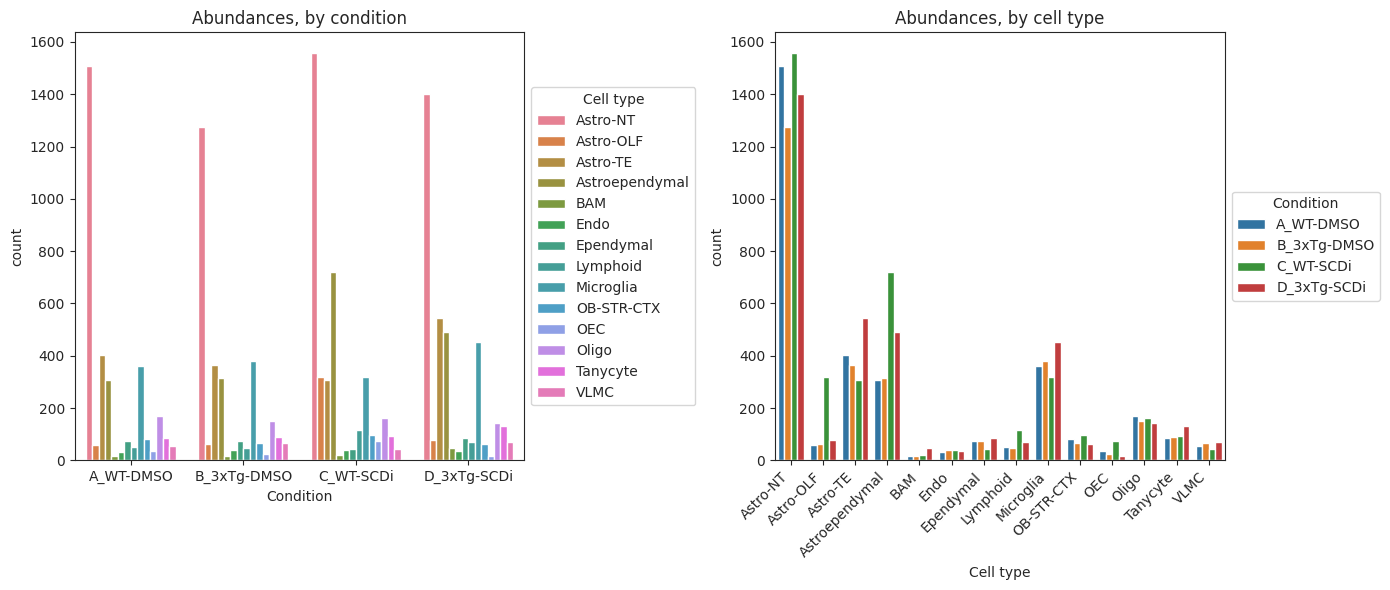

In [8]:
plot_cell_type_abundances(adata)

# Compositional analysis

In [9]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cluster_subclass_name",
    sample_identifier="batch",
    covariate_obs=["Sample_Tag"],
)

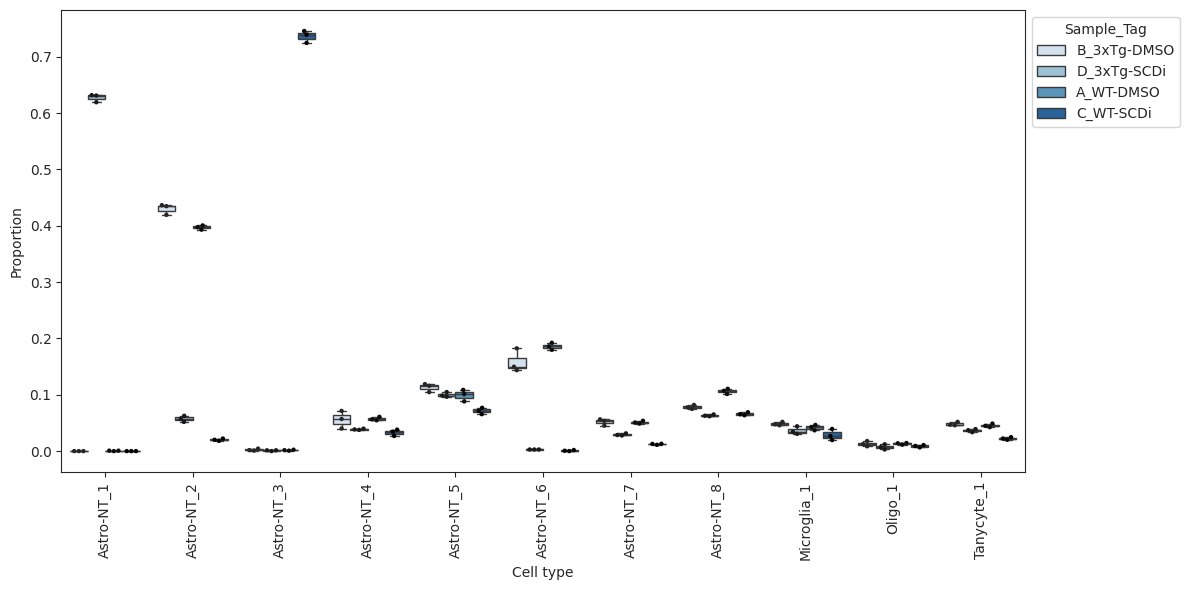

In [10]:
ax = pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="Sample_Tag",
    figsize=(12, 6),
    add_dots=True,
)

# Adjust the dot size if possible
for collection in ax.collections:
    if isinstance(collection, matplotlib.collections.PathCollection):
        collection.set_sizes([10])  # Adjust this value to make dots smaller

plt.tight_layout()
plt.savefig('figures/coda_boxplots.png', bbox_inches='tight')
plt.show()

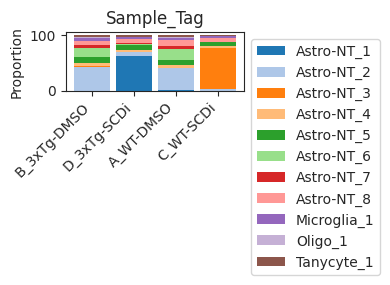

In [11]:
pt.pl.coda.stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="Sample_Tag", figsize=(4, 2)
)
plt.tight_layout()
plt.savefig('figures/coda_stacked_barplot.png',bbox_inches='tight')
plt.show()

In [12]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Sample_Tag",
    reference_cell_type="automatic",
)

Automatic reference selection! Reference cell type set to Oligo_1

Zero counts encountered in data! Added a pseudocount of 0.5.

In [13]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

sample: 100%|█| 11000/11000 [30:58<00:00,  5.92it/s, 1023 steps of size 3.98e-03


In [14]:
sccoda_model.set_fdr(sccoda_data, 0.05)

In [15]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                  Cell Type  
Sample_Tag[T.B_3xTg-DMSO]  Astro-NT_1     False
                           Astro-NT_2     False
                           Astro-NT_3     False
                           Astro-NT_4     False
                           Astro-NT_5     False
                           Astro-NT_6      True
                           Astro-NT_7     False
                           Astro-NT_8      True
                           Microglia_1    False
                           Oligo_1        False
                           Tanycyte_1     False
Sample_Tag[T.C_WT-SCDi]    Astro-NT_1     False
                           Astro-NT_2      True
                           Astro-NT_3      True
                           Astro-NT_4     False
                           Astro-NT_5     False
                           Astro-NT_6      True
                           Astro-NT_7      True
                           Astro-NT_8     False
                           Microglia_1    False
 

In [16]:
credible_effects = sccoda_model.credible_effects(sccoda_data, modality_key="coda")

# Converting the credible_effects to a pandas DataFrame
credible_effects_df = pd.DataFrame(credible_effects)
print(credible_effects_df)

                                       Final Parameter
Covariate                 Cell Type                   
Sample_Tag[T.B_3xTg-DMSO] Astro-NT_1             False
                          Astro-NT_2             False
                          Astro-NT_3             False
                          Astro-NT_4             False
                          Astro-NT_5             False
                          Astro-NT_6              True
                          Astro-NT_7             False
                          Astro-NT_8              True
                          Microglia_1            False
                          Oligo_1                False
                          Tanycyte_1             False
Sample_Tag[T.C_WT-SCDi]   Astro-NT_1             False
                          Astro-NT_2              True
                          Astro-NT_3              True
                          Astro-NT_4             False
                          Astro-NT_5             False
          

In [17]:
credible_effects_df

Final Parameter
Covariate                 Cell Type                   
Sample_Tag[T.B_3xTg-DMSO] Astro-NT_1             False
                          Astro-NT_2             False
                          Astro-NT_3             False
                          Astro-NT_4             False
                          Astro-NT_5             False
                          Astro-NT_6              True
                          Astro-NT_7             False
                          Astro-NT_8              True
                          Microglia_1            False
                          Oligo_1                False
                          Tanycyte_1             False
Sample_Tag[T.C_WT-SCDi]   Astro-NT_1             False
                          Astro-NT_2              True
                          Astro-NT_3              True
                          Astro-NT_4             False
                          Astro-NT_5             False
                          Astro-NT_6              True
                          Astro-NT_7              True
                          Astro-NT_8             False
                          Microglia_1            False
                          Oligo_1                False
                          Tanycyte_1             False
Sample_Tag[T.D_3xTg-SCDi] Astro-NT_1              True
                          Astro-NT_2              True
                          Astro-NT_3             False
                          Astro-NT_4             False
                          Astro-NT_5              True
                          Astro-NT_6              True
                          Astro-NT_7             False
                          Astro-NT_8             False
                          Microglia_1            False
                          Oligo_1                False
                          Tanycyte_1             False

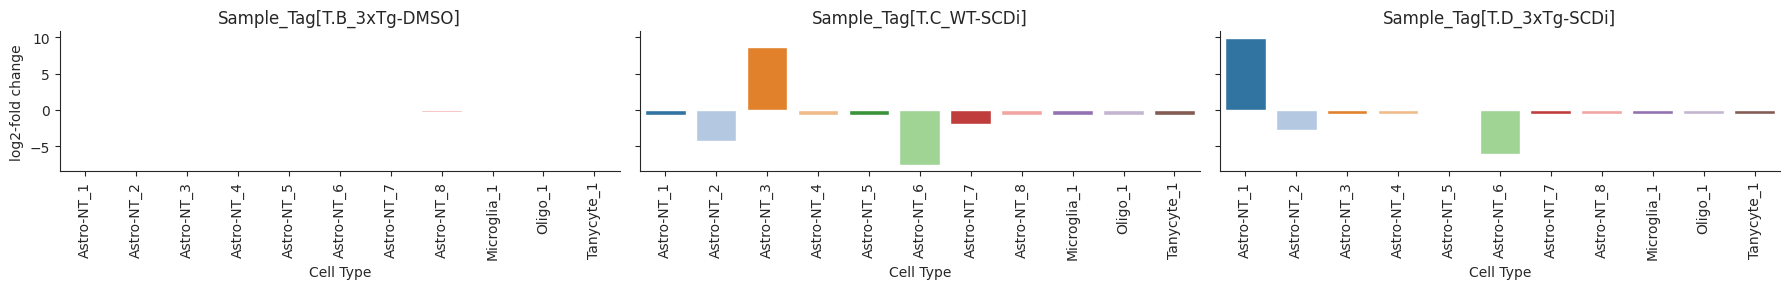

In [18]:
pt.pl.coda.effects_barplot(sccoda_data, "coda", "Sample_Tag")
plt.tight_layout()
plt.savefig('figures/coda_effects_barplot.png', bbox_inches='tight')
plt.show()